In [1]:
import os
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)
from easyFSL_helper import *

from torch.utils.tensorboard import SummaryWriter

Device cpu
Device cpu


In [2]:
train_transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
batch_size = 64
path = 'archive\CUB_200_2011'

N = 10
K = 5
n_query = 10
n_tasks_per_epoch = 50
n_validation_tasks = 20

train_set = CUB(split="train", training=True)
val_set = CUB(split="val", training=False)

print("Train: {}".format(len(train_set)))
print("Valid: {}".format(len(val_set)))

Train: 8245
Valid: 1780


In [4]:
train_sampler = TaskSampler(train_set, n_way=N, n_shot=K, n_query=n_query, n_tasks=n_tasks_per_epoch)
val_sampler = TaskSampler(val_set, n_way=N, n_shot=K, n_query=n_query, n_tasks=n_validation_tasks)

train_loader = data.DataLoader(
    train_set,
    batch_sampler=train_sampler,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)
val_loader = data.DataLoader(
    val_set,
    batch_sampler=val_sampler,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

In [5]:
resnet = models.resnet18()
few_shot_classifier = PrototypicalNetworks(resnet).to(device)
few_shot_classifier.load_state_dict(torch.load('models\our_experiment\model80.pt'))

<All keys matched successfully>

In [6]:
loss_module = nn.CrossEntropyLoss()
optimizer = optim.AdamW(few_shot_classifier.parameters(), lr=0.001, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)
# optimizer = optim.Adam(few_shot_classifier.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [ ]:
import copy
def train_model(model, optimizer, scheduler, train_data_loader, loss_module, num_epochs=100, logging_dir='runs/our_experiment'):
    model_dir = logging_dir.split('/')[-1]
    os.makedirs(logging_dir, exist_ok=True)
    os.makedirs(f'models/{model_dir}', exist_ok=True)
    writer = SummaryWriter(logging_dir)

    best_validation_accuracy = 0.0

    for epoch in range(num_epochs + 100):
        model.train()
        epoch_loss = 0.0
        for support_images, support_labels, query_images, query_labels, _ in tqdm(train_data_loader, 'Epoch %d'%(epoch + 1)):

            model.process_support_set(support_images.to(device), support_labels.to(device))
            classification_scores = model(query_images.to(device))

            loss = loss_module(classification_scores, query_labels.to(device))

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            epoch_loss += loss.item() * len(support_images)

        epoch_loss /= len(train_data_loader.dataset)

        # Calling scheduler
        scheduler.step(epoch_loss)
        # scheduler.step()

        validation_accuracy, val_loss, _, _, f1, _= evaluate(model, loss_module, val_loader, device=device, tqdm_prefix="Validation")

        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            best_state = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f'models/{model_dir}/model{epoch + 1}.pt')
            print("Found a new best model.")

        writer.add_scalars('loss', {'train': epoch_loss,
                                    'val': val_loss}, epoch + 1)

        writer.add_scalar("Val_acc", validation_accuracy, epoch + 1)
        writer.add_scalar("F1", f1, epoch + 1)

        # if((epoch + 1) % 10 == 0):
        #   torch.save(model.state_dict(), f'models/{model_dir}/model{epoch + 1}.pt')

    writer.close()

In [ ]:
train_model(few_shot_classifier, optimizer, scheduler, train_loader, loss_module, num_epochs=100)

In [ ]:
def visualize_training(train_loss, val_loss, train_acc, val_acc):
  plt.figure(figsize=[4,3])
  plt.plot(train_loss,'r',linewidth=1.0)
  plt.plot(val_loss,'b',linewidth=1.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=8)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss',fontsize=16)

  # Accuracy Curves
  plt.figure(figsize=[4,3])
  plt.plot(train_acc,'r',linewidth=1.0)
  plt.plot(val_acc,'b',linewidth=1.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=8)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy',fontsize=16)

In [7]:
class ClassData:
    def __init__(self, support_dir, query_dir, class_name, label, cro_name, description, transform=None):
        self.class_name = class_name
        self.label = label
        self.cro_name = cro_name
        self.description = description
        self.images = []

        support_images_paths = [os.path.join(support_dir, filename) for filename in os.listdir(support_dir)]
        query_images_paths = [os.path.join(query_dir, filename) for filename in os.listdir(query_dir)]

        for image_path in support_images_paths:
            image = Image.open(image_path)
            if transform:
                image = transform(image)
            self.images.append(image)

        for image_path in query_images_paths:
            image = Image.open(image_path)
            if transform:
                image = transform(image)
            self.images.append(image)

        self.images = torch.stack(self.images)
        self.len = len(self.images)

    def __len__(self):
        return self.len

    @classmethod
    def get_class_data(cls, dataset_dir, class_label_map_json, transform=None):
        sets = {}

        with open(class_label_map_json, 'r') as f:
            class_label_map = json.load(f)

        for class_name, attributes in class_label_map.items():
            label = attributes['label']
            cro_name = attributes['cro_name']
            description = attributes['description']

            class_dir = os.path.join(dataset_dir, class_name)
            if os.path.isdir(class_dir):
                support_dir = os.path.join(class_dir, "support")
                query_dir = os.path.join(class_dir, "query")
                sets[label] = cls(support_dir, query_dir, class_name, label, cro_name, description, transform)

        return sets


class CustomDataset(data.Dataset):
    def __init__(self, class_data):
        self.class_data = class_data
        self.images = []
        self.labels = []

        for label, data in class_data.items():
            self.images.extend(data.images)
            self.labels.extend([label] * len(data))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [14]:
batch_size = 128
dataset_path = 'animals_dataset'
labelmap_path = 'animals_label_map.json'

if dataset_path.__contains__('animals'):
    cmap = 'Blues'
else:
    cmap = 'PuRd'
N = 20
K = 5
n_query = 10


class_data = ClassData.get_class_data(dataset_path, labelmap_path, val_transform)
dataset = CustomDataset(class_data)

resnet = models.resnet34()
few_shot_classifier1 = PrototypicalNetworks(resnet).to(device)
few_shot_classifier1.load_state_dict(torch.load('model33.pt'))
few_shot_classifier = PrototypicalNetworks(backbone=few_shot_classifier1)

loss_module = nn.CrossEntropyLoss()

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [15]:
embeddings_df = predict_embeddings(data_loader, resnet, device=device)
features_dataset = FeaturesDataset.from_dataframe(embeddings_df)

Predicting embeddings:   0%|          | 0/3 [00:00<?, ?batch/s]

In [16]:
task_sampler = TaskSampler(features_dataset, n_way=N, n_shot=K, n_query=n_query, n_tasks=100)

features_loader = DataLoader(features_dataset, batch_sampler=task_sampler, pin_memory=True, collate_fn=task_sampler.episodic_collate_fn)

In [ ]:
accuracy, _, macro_precision, macro_recall, f1, cm= evaluate(few_shot_classifier, loss_module, features_loader, device="cpu")

print(f"Average accuracy : {(100 * accuracy):.6f} %\nMacro precision: {(100 * macro_precision):.6f}%\nMacro recall: {(100 * macro_recall):.6f}%\nF1: {f1}")

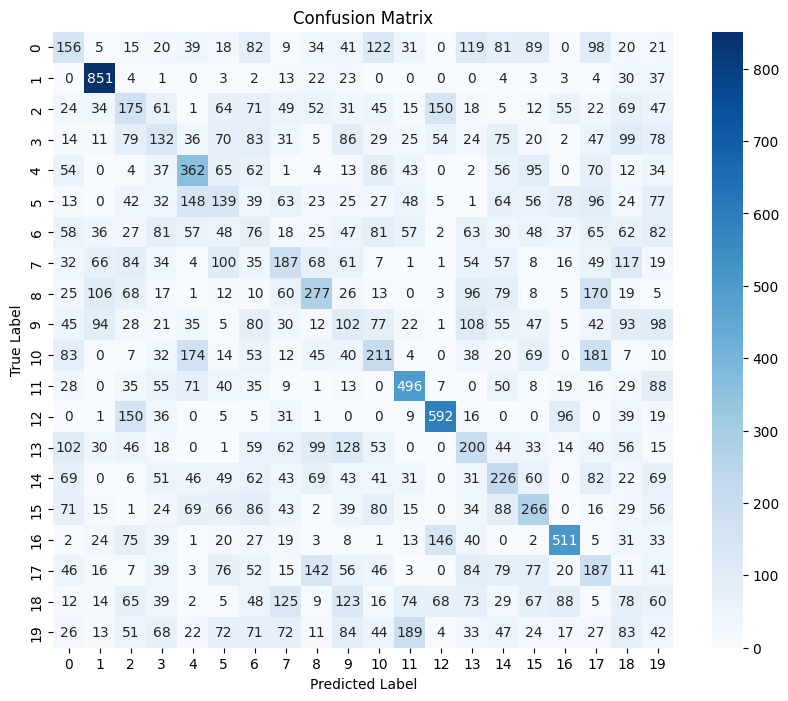

In [15]:
import seaborn as sns
def plot_confusion_matrix(cm: np.ndarray, class_names: List[str]):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, set(dataset.labels))